In [7]:
# Workaround for training output not visible in JupyterNotebook https://github.com/microsoft/vscode-jupyter/issues/13163
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [8]:
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

An image dataset of written number samples.

In [9]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [10]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [11]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [12]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

Representing it as an array and tensor.

In [13]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [14]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

Visual representation of each pixel

In [15]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


In [16]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<Axes: >

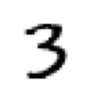

In [17]:
show_image(three_tensors[1])

Stacking all the threes together, and all the sevens together.

In [18]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [19]:
len(stacked_threes.shape)

3

In [20]:
stacked_threes.ndim

3

Visual representation of the mean of all threes and sevens.

<Axes: >

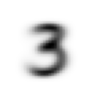

In [21]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

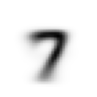

In [22]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

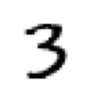

In [23]:
a_3 = stacked_threes[1]
show_image(a_3);

In [24]:
a_3_t = tensor(a_3)
df_a_3 = pd.DataFrame(a_3_t)
df_a_3.style.set_properties(**{'font-size':'6pt'}).background_gradient('Blues')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.113725,0.588235,0.764706,0.996078,1.000000,0.996078,0.690196,0.756863,0.588235,0.376471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.188235,0.650980,0.878431,0.992157,0.992157,0.917647,0.768627,0.992157,0.992157,0.992157,0.992157,0.913725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.364706,0.956863,0.976471,0.992157,0.733333,0.180392,0.039216,0.031373,0.015686,0.039216,0.760784,0.992157,0.992157,0.913725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.419608,0.992157,0.992157,0.901961,0.188235,0.000000,0.000000,0.000000,0.000000,0.000000,0.752941,0.992157,0.992157,0.611765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765,0.078431,0.078431,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.168627,0.878431,0.992157,0.960784,0.290196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Determine the distance of this 3, from the ideal mean 3 by absolute value of differences, or root of mean of square of differences. 

In [25]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

Now the distance of the same 3 to the ideal 7, for comparison. 

In [26]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

Now using Pytorch which provides as loss function. Available in fastai as `F`

In [27]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Create tensors from the validation directory.

In [28]:
validation_3_tensor = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
validation_3_tensor = validation_3_tensor.float()/255

validation_7_tensor = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
validation_7_tensor = validation_7_tensor.float()/255

validation_3_tensor.shape, validation_7_tensor.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Try to figure out the distance between a given digit '3' and the mean '3'. 

In [29]:
def mnist_distance(a,b):
    return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

To do it across the entire validatio nset, same code. Pytorch will expand the 'mean3' to match the dimensions of the validation_3_tensor set and perform substraction. 

In [31]:
validation_3_distance = mnist_distance(validation_3_tensor, mean3)
validation_3_distance, validation_3_distance.shape

(tensor([0.1325, 0.1463, 0.1188,  ..., 0.1571, 0.1329, 0.1611]),
 torch.Size([1010]))

This is called broadcasting

In [32]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

The shape of the 'broadcasted' smaller rank tensor. 

In [34]:

(validation_3_tensor-mean3).shape

torch.Size([1010, 28, 28])

A given image is a 3 if its distance to the ideal 3 is less than the distance to the ideal 7. 

In [35]:
def is_3(given): return mnist_distance(given, mean3) < mnist_distance(given, mean7)
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Test the entire set of validation 3s.

In [36]:
is_3(validation_3_tensor)

tensor([True, True, True,  ..., True, True, True])

Get the mean for the entire validation set.

In [40]:
accuracy_3s = is_3(validation_3_tensor).float().mean()
accuracy_7s = (1-is_3(validation_7_tensor).float()).mean()
accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))